In [ ]:
#default_exp data

In [ ]:
#hide
from IPython.display import clear_output
from nbdev.export import notebook2script

%reload_ext autoreload
%autoreload 2

In [ ]:
#export
import os
import torch
import logging
import warnings
import multiprocessing
from PIL import Image
from dotenv import load_dotenv
from easydict import EasyDict as edict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

_ = load_dotenv()

logger = logging.getLogger()
logger.setLevel("INFO")

In [ ]:
#hide
os.environ['DATA_ROOT'] = os.path.join("..", os.getenv("DATA_ROOT"))

# data

> 下載、載入並前處理數據並建立 Dataset 和 DataLoader 之模組。

## 取得數據根目錄

In [ ]:
#export
def get_data_root(data_root=None):
    data_root = data_root if data_root else os.getenv("DATA_ROOT", ".")
    if not os.path.exists(data_root):
        os.makedirs(data_root)
    return data_root

In [ ]:
predefined_data_root = os.getenv("DATA_ROOT")

if predefined_data_root:
    assert predefined_data_root == get_data_root()
else:
    assert get_data_root("tmp") == "tmp"

In [ ]:
get_data_root()

'../data'

## Generic Dataset / DataLoader

In [ ]:
#export
class ImageOnlyDataset(Dataset):
    """常用於生成任務，只回傳圖片而不回傳標籤的 Dataset"""
    
    def __init__(self, img_label_dataset, img_idx=0):
        self.orig_dataset = img_label_dataset
        self.img_idx = img_idx
        
    def __len__(self):
        return len(self.orig_dataset)
    
    def __getitem__(self, idx):
        return self.orig_dataset[idx][self.img_idx]

## 各類型數據集的實現

### 貼圖

In [ ]:
#export
class Stickers(Dataset):
    def __init__(self, sticker_name=None, size=None):
        # files
        self.root_dir = os.path.join(get_data_root(), "stickers")
        self.sticker_name = sticker_name if sticker_name else "kanahei"
        self.size = size if size else (128, 128)
        self.sticker_dir = os.path.join(self.root_dir, self.sticker_name)
        self.image_paths = None
        
        for dirpath, _, filenames in os.walk(self.root_dir):
            if dirpath == self.sticker_dir:
                self.image_paths = [os.path.join(dirpath, f) for f in filenames]
                break
                
        if not self.image_paths:
            logging.warning(f"{self.sticker_dir} does not exist.")
        
        # stats
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        transform = [
            transforms.ColorJitter(.1, .1, .1, .1),
            transforms.RandomHorizontalFlip(),
#             transforms.Resize((224, 256)),
            transforms.Resize(self.size),
#             transforms.CenterCrop(self.size),
            transforms.ToTensor(),
#             transforms.Normalize(mean=self.mean, std=self.std),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ]
        self.transform = transforms.Compose(transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        return image

## 依據名稱取得數據集的 Helper

In [ ]:
#export
def get_dataset(dataset, split="full", size=None, transform=None, return_label=True, 
                **kwargs):
    
    dataset = dataset.lower()
    if dataset == "mnist":
        size = size if size else (28, 28)
        logging.info(f"MNIST will be resized to {size}.")
        
        transform = transforms.Compose([
            transforms.Resize(size=size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ]) if not transform else transform
        
        root = get_data_root()
        ds_params = dict(root=root, transform=transform, download=True)
        if os.path.exists(os.path.join(root, "MNIST")):
            ds_params['download'] = False
        
        if split == "train":
            ds_params['train'] = True
        elif split == "test":
            ds_params['train'] = False
        dataset = datasets.MNIST(**ds_params)
        
        if not return_label:
            dataset = ImageOnlyDataset(dataset)
            
        
    elif dataset == "stickers":
        sticker_name = kwargs.get("sticker_name", "kanahei")
        size = size if size else (128, 128)
        dataset = Stickers(sticker_name, size=size) 
    else:
        raise NotImplementedError
    
    setattr(dataset, "input_shape", (1, *size))
    return dataset

### MNIST

In [ ]:
mnist = get_dataset("mnist")
x = mnist[0]

assert mnist.input_shape == (1, 28, 28)  # CHW
assert len(mnist) == 60_000
assert len(x) == 2
mnist.input_shape

INFO:root:MNIST will be resized to (28, 28).


(1, 28, 28)

### 切割數據集、改變圖片大小並不回傳標籤
生成任務有時不需要使用標籤資訊。


In [ ]:
size = (32, 32)
mnist_test = get_dataset("mnist", split="test", size=size, return_label=False)
x = mnist_test[0]

assert mnist_test.input_shape == (1, *size)
assert len(mnist_test) == 10_000
assert len(x) == 1
mnist_test.input_shape

INFO:root:MNIST will be resized to (32, 32).


(1, 32, 32)

### 貼圖

In [ ]:
#server
stickers = get_dataset("stickers")
x = stickers[0]

In [ ]:
x.min(), x.max()

(tensor(-2.1179), tensor(2.6400))

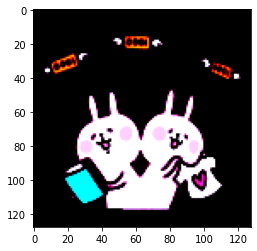

In [ ]:
#server
import matplotlib.pyplot as plt
plt.imshow(x.permute(1, 2, 0));

## 將數據集轉換為 DataLoader

In [ ]:
#export
def get_data_loader(dataset, batch_size, shuffle=True, collate_fn=None, drop_last=True, **kwargs):
    use_cuda = torch.cuda.is_available()
    num_workers = multiprocessing.cpu_count() if use_cuda else 1
    
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                             num_workers=num_workers, collate_fn=collate_fn, 
                             drop_last=drop_last, pin_memory=use_cuda)
    return data_loader

In [ ]:
batch_size = 32
mnist_data_loader = get_data_loader(mnist, batch_size=batch_size)
batch = next(iter(mnist_data_loader))

assert len(batch) == 2
assert batch[0].shape[0] == batch_size

In [ ]:
#hide
notebook2script()
clear_output()